<a href="https://colab.research.google.com/github/bismillahkani/ISL-CV-Team3/blob/master/ASL_Deep_Learning_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing data

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/ISL/asl-alphabet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

Import libraries

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Helper function to plot learning curves

def plot_training(history):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(history.history["val_loss"], label="val_loss")
    ax.plot(history.history["loss"], label="train_loss")
    ax.set_title("validation/training loss")
    ax.set_xlabel("epochs")
    ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(history.history["val_acc"], label="val_acc")
    ax2.plot(history.history["acc"], label="train_acc")
    ax2.set_title("validation/training accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0, 1)
    ax2.legend()

    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Visualize data

In [5]:
alphabet = 'H'

alphabet_dir = os.path.join('/tmp/asl_alphabet_train/asl_alphabet_train/' + alphabet)

print('total training alphabet H images:', len(os.listdir(alphabet_dir)))

alphabet_files = os.listdir(alphabet_dir)
print(alphabet_files[:10])

total training alphabet H images: 3000
['H2286.jpg', 'H1240.jpg', 'H48.jpg', 'H314.jpg', 'H162.jpg', 'H224.jpg', 'H1241.jpg', 'H2466.jpg', 'H2082.jpg', 'H2274.jpg']


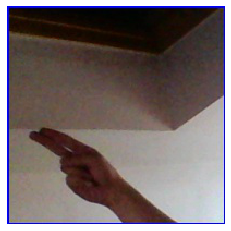

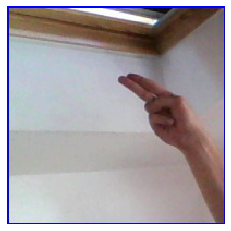

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_alphabet = [os.path.join(alphabet_dir, fname) 
                for fname in alphabet_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_alphabet):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [7]:
alphabet = 'A'

alphabet_dir = os.path.join('/content/drive/My Drive/ISL/train/' + alphabet)

print('total training alphabet A images:', len(os.listdir(alphabet_dir)))

alphabet_files = os.listdir(alphabet_dir)
print(alphabet_files[:10])

total training alphabet A images: 242
['001.jpg', '007.jpg', '004.jpg', '005.jpg', '002.jpg', '003.jpg', '006.jpg', '010.jpg', '008.jpg', '009.jpg']


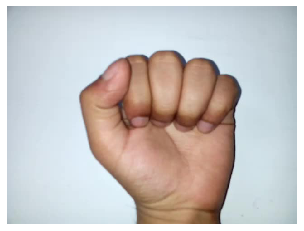

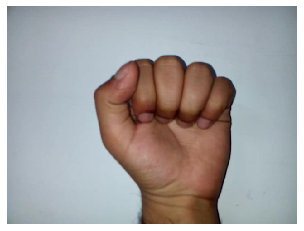

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_alphabet = [os.path.join(alphabet_dir, fname) 
                for fname in alphabet_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_alphabet):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [9]:
img.shape

(480, 640, 3)

Image Generator

In [49]:
data_dir = "/tmp/asl_alphabet_train/asl_alphabet_train"
#data_dir = '/content/drive/My Drive/ISL/train/'
target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB
n_classes = 29
#n_classes = 24
val_frac = 0.2
batch_size = 20

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

callback = ModelCheckpoint('/content/drive/My Drive/ISL/asl.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [11]:
total_samples = sum([len(files) for root, directory, files in os.walk(data_dir)]) 
total_val = int(val_frac * total_samples)
total_train = total_samples - total_val
print('total training images:', total_train)
print('total validation images:', total_val)

total training images: 69600
total validation images: 17400


In [0]:
#input_size = (200,200)
#input_dims = (200,200,3)
#numclasses = 29

#TRAINING_DIR = '/tmp/asl_alphabet_train/asl_alphabet_train'
#datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

#train_generator = datagen.flow_from_directory(
#    TRAINING_DIR,
#    target_size=input_size,
#    class_mode='categorical',
#    subset = 'training'    
#)

#validation_generator = datagen.flow_from_directory(
#    TRAINING_DIR,
#    target_size=input_size,
#    class_mode='categorical',
#    subset = 'validation'    
#)

Model 1.1 - CNN

In [15]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=target_dims))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

sgd = optimizers.SGD(lr=0.0001)
adam = optimizers.Adam(lr=0.0001)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1, callbacks=[callback])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)        

Model 1.1 - Accuracy

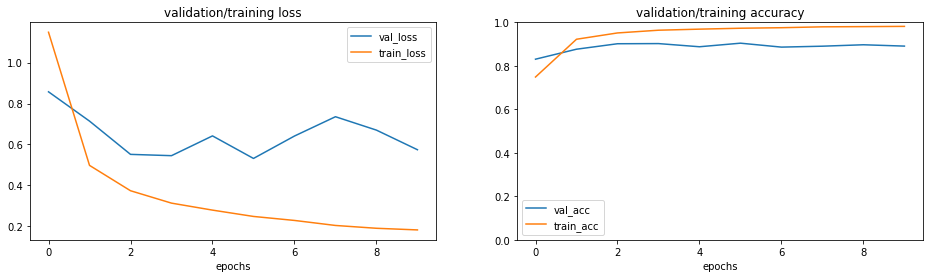

In [43]:
plot_training(history)

In [33]:
17400 / 29

600.0

In [54]:
#Confusion Matrix and Classification Report
model.load_weights('/content/drive/My Drive/ISL/asl.hdf5')
Y_pred = model.predict_generator(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

870/870 [==============================] - 20s 23ms/step
Confusion Matrix
[[20 24 13 26 25 14 25 29 13 10 26 25 32 17 26 21 16 24 29 24 19 17 17 13
  24 19 16 12 24]
 [17 22 18 22 21 20 15 19 17 19 18 28 36 16 17 15 25 27 26 20 20 16 22 10
  27 22 26 18 21]
 [32 15 20 22 13 13 18 29 25 20 24 21 32 16 26 15 17 21 26 15 18 18 24 10
  21 31 25 19 14]
 [21 27 15 20 21 24 11 31 16 30 21 18 28 13 18 28 18 24 23 21 19 19 27 10
  17 19 26 13 22]
 [17 32 20 21 18 20 23 23 17 17 19 17 34 13 16 23 20 25 26 11 22 11 20 12
  24 22 24 30 23]
 [19 22 25 15 17 23 11 20 17 22 15 27 27 22 28 18 19 38 23 29 21 11 16 13
  17 23 17 26 19]
 [28 21 21 16 32 24 12 26 22 18 19 24 26 16 20 20 21 22 25 16 23 18 20 13
  13 24 19 25 16]
 [20 22 17 17 23 24 20 26 21 17 22 18 27 12 16 23 25 22 23 14 23 19 25  8
  20 20 27 19 30]
 [14 31 16 17 27 16 17 22 11 13 24 19 28 23 24 21 20 23 23 23 25 16 37 10
  14 19 22 21 24]
 [13 23 27 27 21 17 18 18 18 21 25 18 19 13 24 22 22 24 18 14 15 28 27 17
  18 21 15 32 25]
 [21 2

In [50]:
print(val_generator.classes[:10])

[0 0 0 0 0 0 0 0 0 0]


In [51]:
print(y_pred[:10])

[19 24 27 11  1  6  5 11 14 23]


In [55]:
print(accuracy_score(val_generator.classes, y_pred))

0.032126436781609195


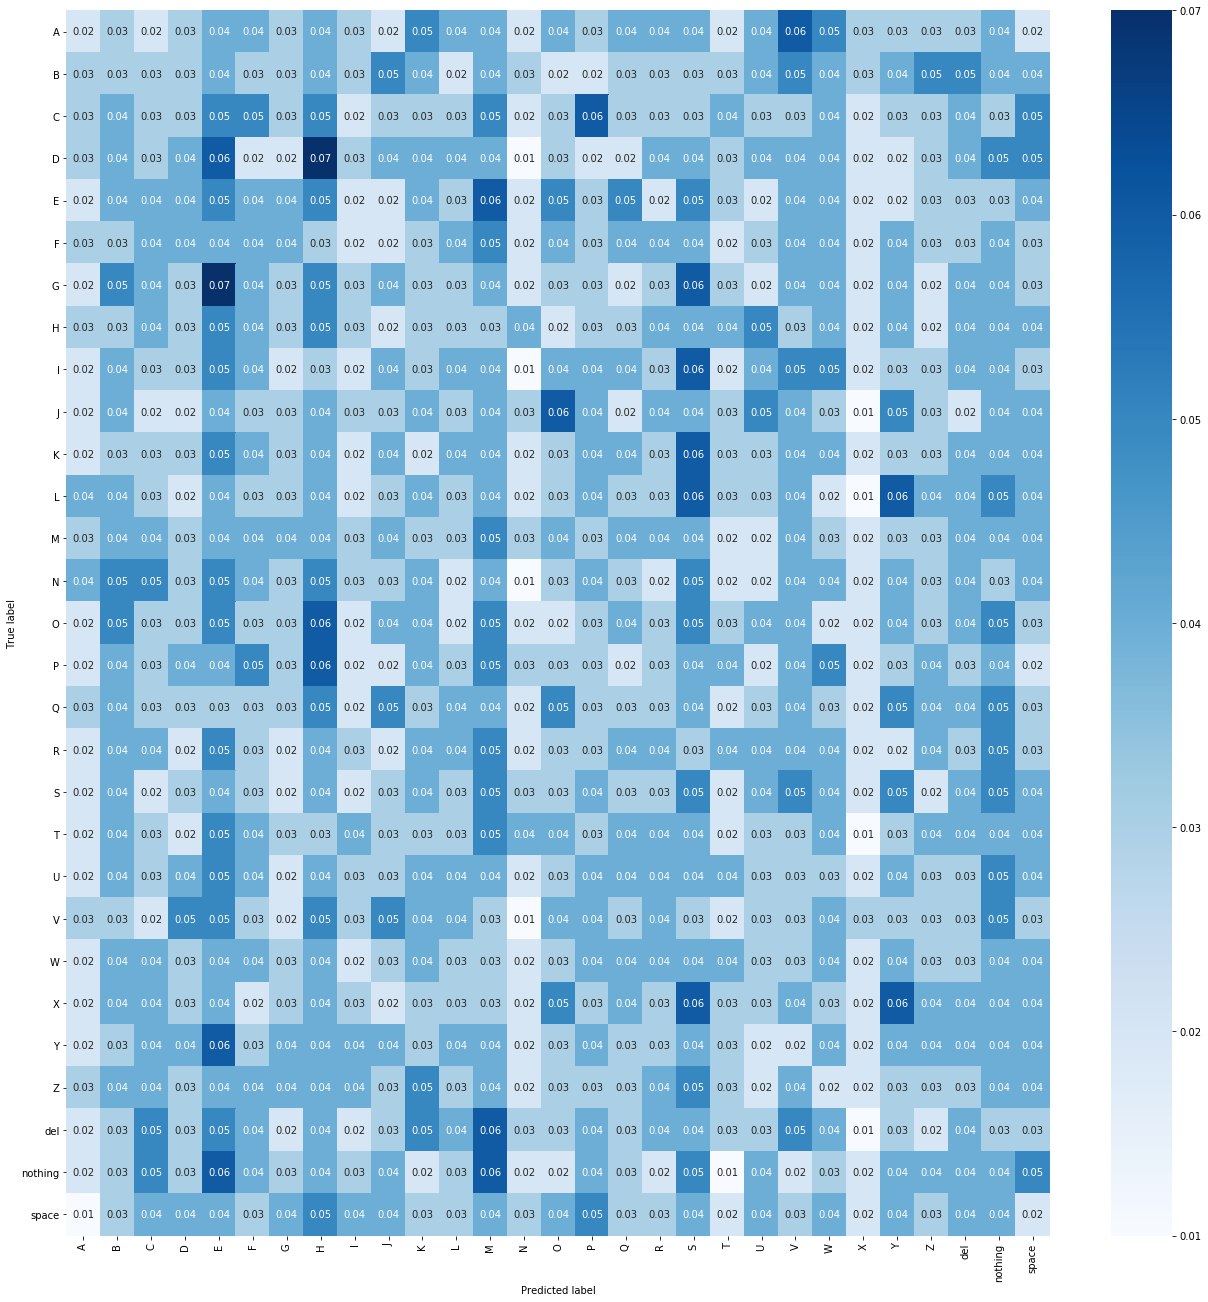

In [32]:
con_mat = confusion_matrix(val_generator.classes, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = target_names, columns = target_names)

figure = plt.figure(figsize=(18, 18))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model 1.2 - CNN

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=target_dims, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, clipnorm=1.0),
              metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)

Epoch 1/10
3480/3480 [==============================] - 132s 38ms/step - loss: 1.4089 - acc: 0.5798 - val_loss: 1.6230 - val_acc: 0.5495
Epoch 2/10
3480/3480 [==============================] - 128s 37ms/step - loss: 0.3247 - acc: 0.8939 - val_loss: 1.7140 - val_acc: 0.6222
Epoch 3/10
3480/3480 [==============================] - 128s 37ms/step - loss: 0.1535 - acc: 0.9495 - val_loss: 2.0762 - val_acc: 0.6511
Epoch 4/10
3480/3480 [==============================] - 127s 37ms/step - loss: 0.0978 - acc: 0.9685 - val_loss: 2.2473 - val_acc: 0.6539
Epoch 5/10
3480/3480 [==============================] - 128s 37ms/step - loss: 0.0693 - acc: 0.9785 - val_loss: 2.4879 - val_acc: 0.6794
Epoch 6/10
3480/3480 [==============================] - 128s 37ms/step - loss: 0.0549 - acc: 0.9842 - val_loss: 2.6021 - val_acc: 0.6874
Epoch 7/10
3480/3480 [==============================] - 127s 37ms/step - loss: 0.0445 - acc: 0.9872 - val_loss: 2.9145 - val_acc: 0.6828
Epoch 8/10
3480/3480 [===================

Model 1.3 - CNN

In [36]:
model = Sequential()
model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=target_dims))
model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 128)       0         
_

Model 1.3 - Accuracy

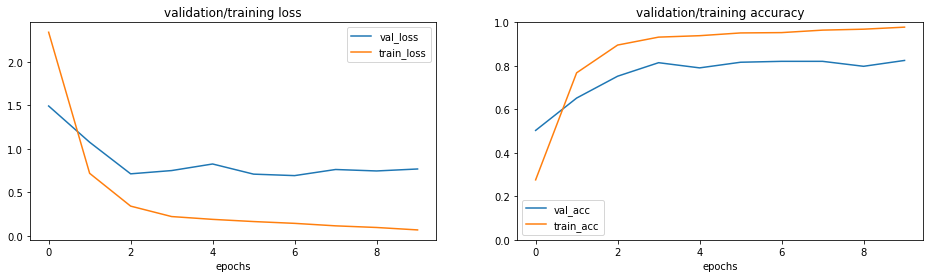

In [39]:
plot_training(history)

Model 3 - pre-trained VGG 16

In [50]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=target_dims)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Freezing the Conv layers from VGG16
for layer in base_model.layers:
  layer.trainable = False
  print(layer.name,layer.trainable)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)

input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
Epoch 1/10
3480/3480 [==============================] - 105s 30ms/step - loss: 0.1745 - acc: 0.9501 - val_loss: 1.4379 - val_acc: 0.7130
Epoch 2/10
3480/3480 [==============================] - 103s 30ms/step - loss: 0.0416 - acc: 0.9872 - val_loss: 1.6511 - val_acc: 0.7549
Epoch 3/10
3480/3480 [==============================] - 103s 30ms/step - loss: 0.0311 - acc: 0.9906 - val_loss: 1.6637 - val_acc: 0.7729
Epoch 4/10
3480/3480 [==============================] - 104s 30ms/step - loss: 0.0252 - acc: 0.9929 - val_loss: 1.6193 - val_acc: 0.7953
Epoch 5/10
3480/3480 [==============================] - 105s 30ms/step - loss: 0.0250 - acc: 0.9932 -

KeyboardInterrupt: ignored

Model 3 - Accuracy

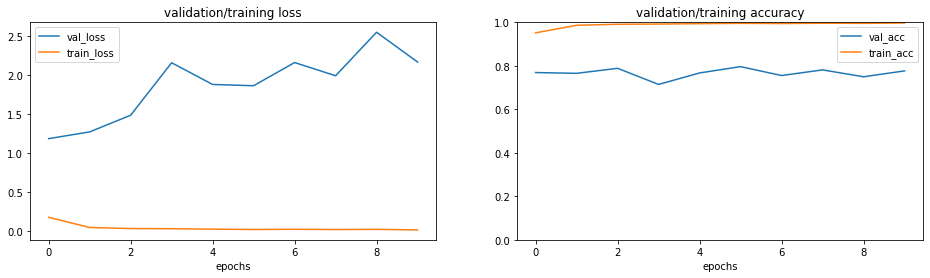

In [49]:
plot_training(history)

Model 7  - Fine Tuning VGG16


In [12]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=target_dims)

# adding the base_model to a block of fully connected layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Unfreezing the last conv_block
for layer in base_model.layers[:15]:
  layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

# Just ensuring the correct layers are frozen
for layer in base_model.layers:
  print(layer.name,layer.trainable)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)





58892288/58889256 [==============================] - 2s 0us/step






input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3480/3480 [==============================] - 160s 46ms/step - loss: 3.3687 - acc: 0.0339 - val_loss: 3.3674 - val_acc: 0.0345
Epoch 2/10
1919/3480 [===============>..............] - ETA: 58s - loss: 3.3677 - acc: 0.0329

KeyboardInterrupt: ignored

Model 8 - VGG16 Transferred Features

In [18]:
pre_trained_model = VGG16(weights = 'imagenet', include_top=False, input_shape=target_dims)

for layer in pre_trained_model.layers:
  layer.trainable = False

layer_name = 'block4_conv1'
  
# pre_trained_model.summary()
intermediate_layer = pre_trained_model.get_layer(layer_name)
print('last layer output shape: ', intermediate_layer.output_shape)
intermediate_output = intermediate_layer.output

x = layers.MaxPooling2D(pool_size=(2,2))(intermediate_output)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(n_classes, activation='softmax')(x)   

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = optimizers.RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)

last layer output shape:  (None, 8, 8, 512)


AttributeError: ignored

Model 4 - InceptionV3

In [53]:
data_dir = "/tmp/asl_alphabet_train/asl_alphabet_train"
target_size = (150, 150)
target_dims = (150, 150, 3) # add channel for RGB
n_classes = 29
val_frac = 0.2
batch_size = 20

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [54]:
base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=target_dims)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Freezing the Conv layers from VGG16
for layer in base_model.layers:
  layer.trainable = False
  print(layer.name,layer.trainable)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)

input_6 False
conv2d_101 False
batch_normalization_95 False
activation_95 False
conv2d_102 False
batch_normalization_96 False
activation_96 False
conv2d_103 False
batch_normalization_97 False
activation_97 False
max_pooling2d_5 False
conv2d_104 False
batch_normalization_98 False
activation_98 False
conv2d_105 False
batch_normalization_99 False
activation_99 False
max_pooling2d_6 False
conv2d_109 False
batch_normalization_103 False
activation_103 False
conv2d_107 False
conv2d_110 False
batch_normalization_101 False
batch_normalization_104 False
activation_101 False
activation_104 False
average_pooling2d_10 False
conv2d_106 False
conv2d_108 False
conv2d_111 False
conv2d_112 False
batch_normalization_100 False
batch_normalization_102 False
batch_normalization_105 False
batch_normalization_106 False
activation_100 False
activation_102 False
activation_105 False
activation_106 False
mixed0 False
conv2d_116 False
batch_normalization_110 False
activation_110 False
conv2d_114 False
conv2d_117 

KeyboardInterrupt: ignored

Model 4 - Accuracy

In [0]:
plot_training(history)

Model 5 - Fine tuning Inception

In [62]:
ase_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=target_dims)

# adding the base_model to a block of fully connected layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 5, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)

Epoch 1/5
3480/3480 [==============================] - 192s 55ms/step - loss: 3.3675 - acc: 0.0330 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 2/5
 117/3480 [>.............................] - ETA: 2:18 - loss: 3.3674 - acc: 0.0385

KeyboardInterrupt: ignored

Model 5 - Accuracy

In [0]:
plot_training(history)

Model 6 - Inception Transfered Features

In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-02-26 14:13:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  60.1MB/s    in 1.4s    

2020-02-26 14:13:25 (60.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (n_classes, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

history = model.fit_generator(train_generator, steps_per_epoch = (total_train // batch_size), epochs = 10, validation_data = val_generator, validation_steps = (total_val // batch_size), verbose = 1)

Epoch 1/10
1000/1000 [==============================] - 162s 162ms/step - loss: 0.3665 - acc: 0.9068 - val_loss: 5.6887 - val_acc: 0.3922
Epoch 2/10
1000/1000 [==============================] - 167s 167ms/step - loss: 2.6137 - acc: 0.2509 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 3/10
1000/1000 [==============================] - 161s 161ms/step - loss: 3.3673 - acc: 0.0345 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 4/10
 575/1000 [================>.............] - ETA: 55s - loss: 3.3673 - acc: 0.0335

KeyboardInterrupt: ignored

Predicting test data

In [0]:
import numpy as np
from keras.preprocessing import image

test_path = '/tmp/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_path)

for file in files:
  full_file = os.path.join(test_path,file)
  img = image.load_img(full_file, target_size=image_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(file)
  print(classes)

Z_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0.]]
space_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1.]]
U_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0.]]
X_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0.]]
A_test.jpg
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
V_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0.]]
H_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
M_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
B_test.jpg
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
Q_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=image_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving O_test.jpg to O_test.jpg
O_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
